<a href="https://colab.research.google.com/github/heejeongJ/DL_pt/blob/Autoencoder-%234/Autoencoder_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9912422/9912422 [00:00<00:00, 107875101.18it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33151530.88it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29525817.98it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1150533.20it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

cuda:0
Epoch [0/10], Loss: 0.0178
Epoch [1/10], Loss: 0.0154
Epoch [2/10], Loss: 0.0143
Epoch [3/10], Loss: 0.0138
Epoch [4/10], Loss: 0.0129
Epoch [5/10], Loss: 0.0065
Epoch [6/10], Loss: 0.0061
Epoch [7/10], Loss: 0.0059
Epoch [8/10], Loss: 0.0054
Epoch [9/10], Loss: 0.0051


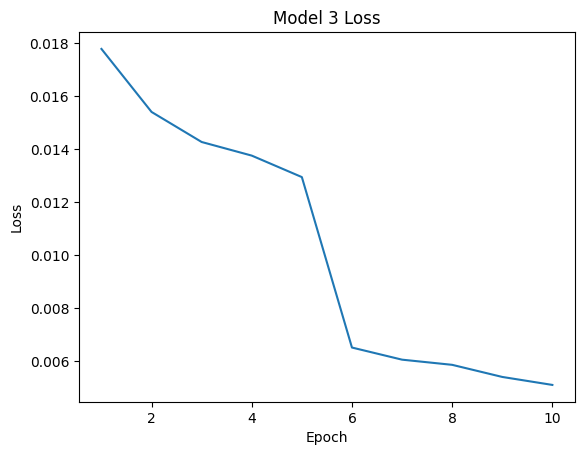

torch.Size([256, 28, 28])


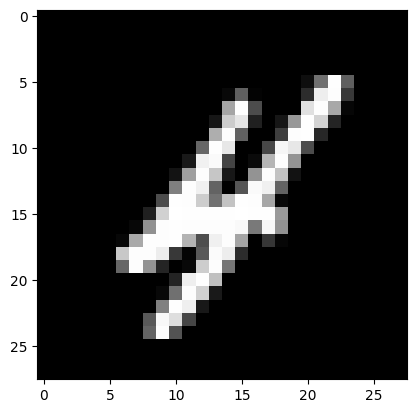

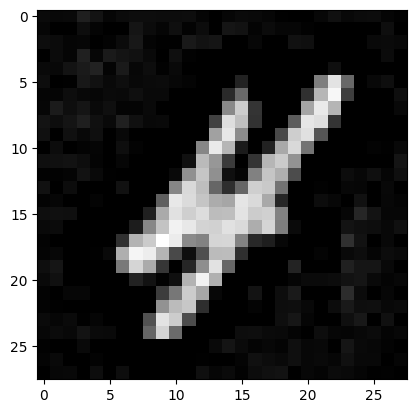

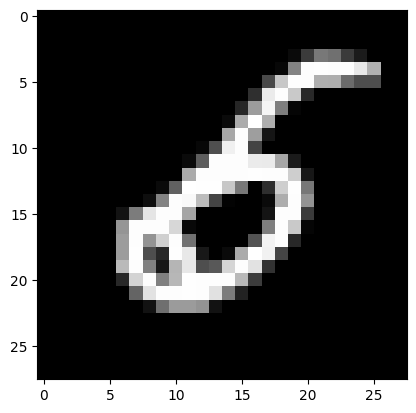

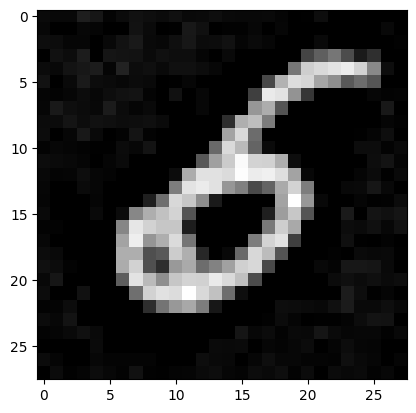

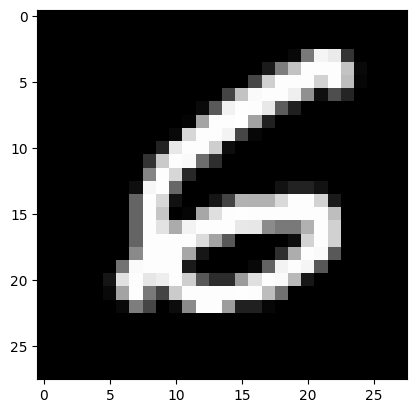

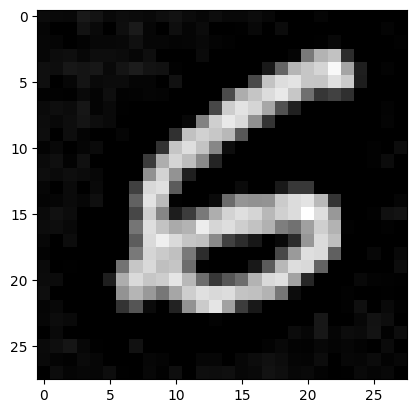

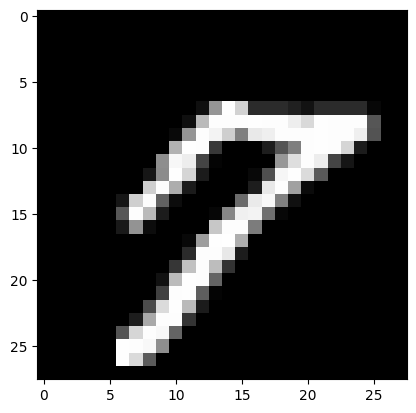

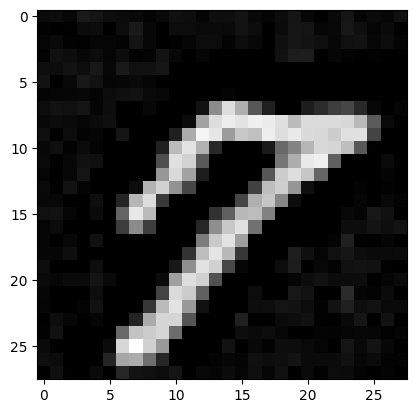

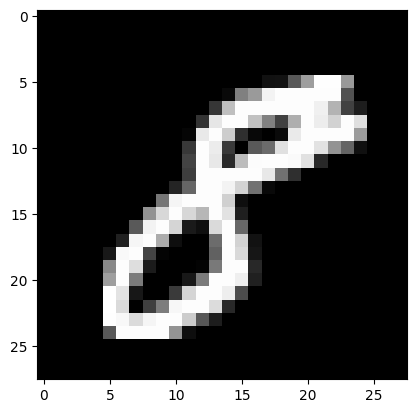

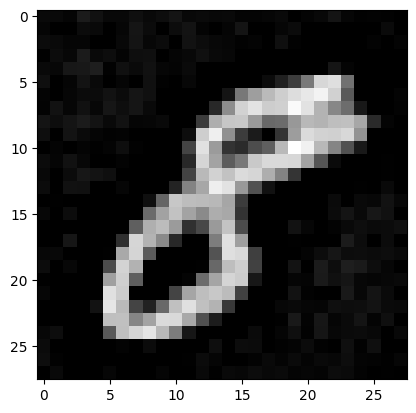

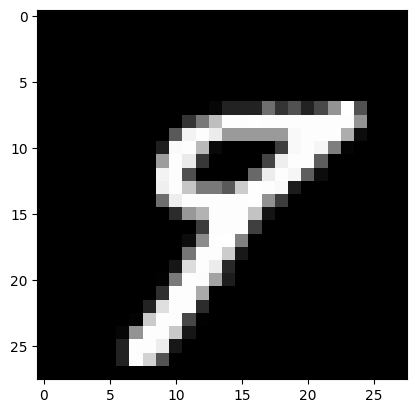

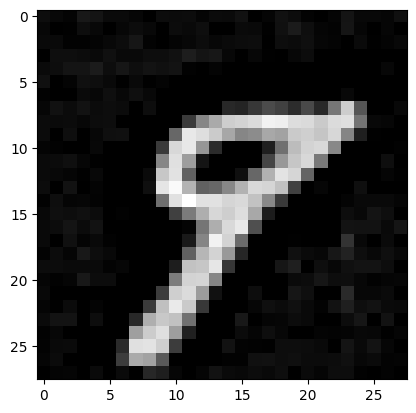

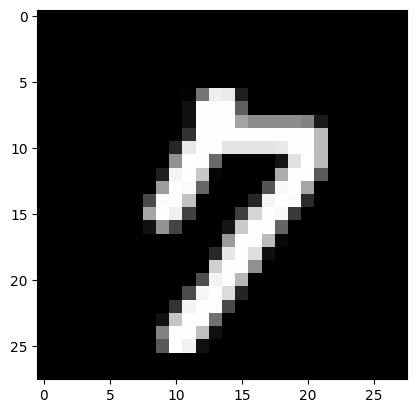

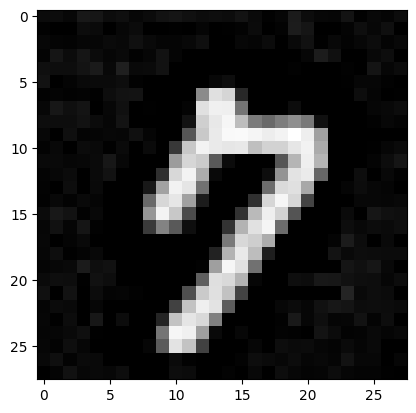

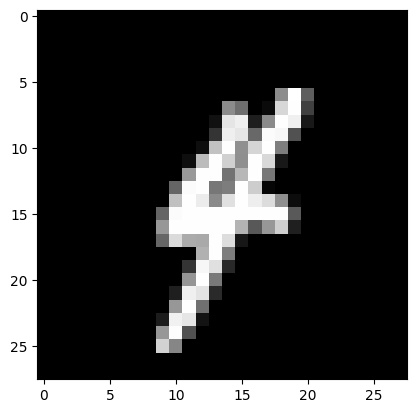

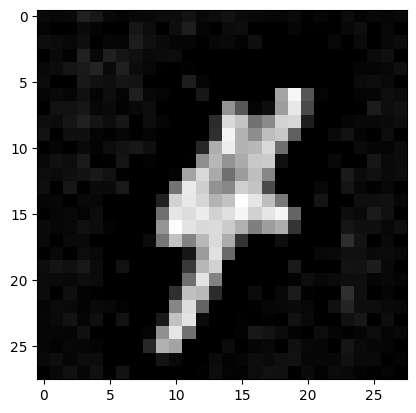

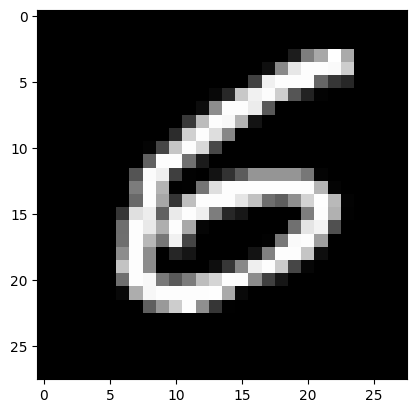

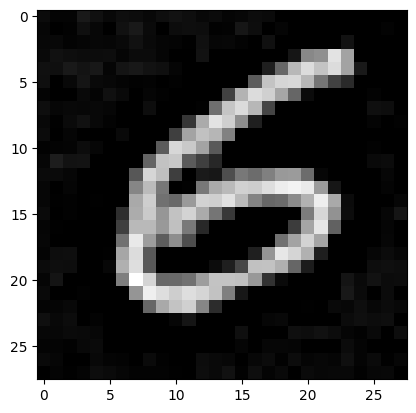

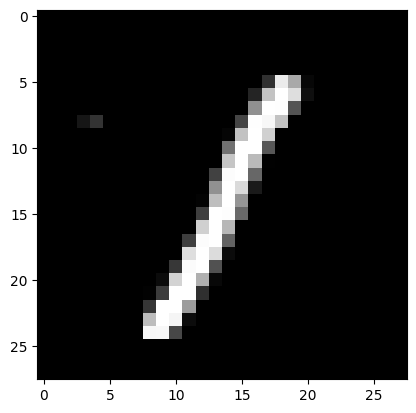

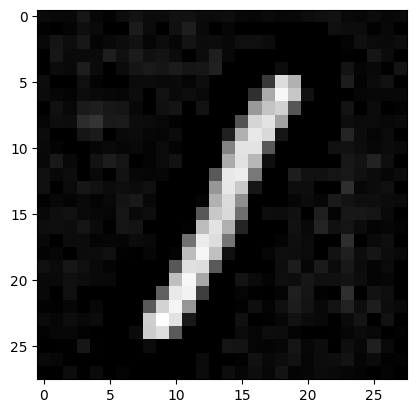

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 하이퍼 파라미터 지정
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 데이터 다운로드
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# DataLoader 설정
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# [합성곱] 모델 선언 - Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

# [합성곱] 모델 선언 - Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
            nn.ReLU()
        )

    def forward(self, x):
        out = x.view(batch_size, 256, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

# [합성곱] 손실 함수, 최적화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

# [합성곱] 학습
noise_std = 0.1  # 노이즈 레벨 조정

losses = []  # 손실값 저장 리스트

for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # 입력 이미지에 랜덤 가우시안 노이즈 추가
        noisy_images = images + noise_std * torch.randn_like(images)
        noisy_images = torch.clamp(noisy_images, 0, 1)  # 픽셀 값이 [0, 1] 범위에 있도록 보장

        noisy_images = noisy_images.to(device)  # GPU로 옮기기
        output = encoder(noisy_images)
        output = decoder(output)

        loss = loss_func(output, noisy_images)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    print(f'Epoch [{epoch}/{num_epoch}], Loss: {loss.item():.4f}')

# Loss 그래프 출력
plt.plot(range(1, num_epoch + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss')
plt.show()

# 훈련 영상을 통한 확인
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        x = images.to(device)

        optimizer.zero_grad()
        output = encoder(x)
        output = decoder(output)

    if i % 1000 == 0:
        print(loss)

# 테스트 영상을 통한 확인(최종 결과 확인)
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(images[i]).numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()
